# Trace Demo

This notebook uses the trace package to run through multiple example calculations. The following are included:

1. A toy example
2. Verifying the lensmaker's equation
3. Calculating RMS of plano-convex lens
4. Optimizing a lens
5. Modeling and optimizing a telescope

The idea is to demonstrate increasingly advanced usage of trace.

**NOTICE:**<br>
Each section in the notebook can be run independently, but *must be run in order*!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import trace as tr

In [2]:
# Can be fun for interactive 3D graphics
# %matplotlib notebook

## Basic Usage (Toy Example)

The following demonstrates the basic principles of trace.

In [3]:
# Make a scene and include a lense
scene = tr.Scene()

# Convex at origin, pointing upwards
lens = tr.SphereLens(.1, 0.8, 1, pos=tr.pos(0, 0, 0), axis=tr.vec(0, 0, 1), n=2.0)
lamp = tr.DenseSource(pos=tr.pos(0, 0, 2), k=tr.vec(0, 0, -1), radius=0.8)

In [4]:
# Add the elements to the simulation and run (notice that many elements can be added at once)
scene.add(lens, lamp)
scene.trace()

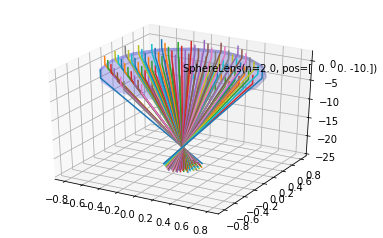

In [5]:
# Show result
tr.graphics.render_3d(scene, extend=25)
plt.show()

## Verifying the Lensmaker's Equation

Here we use trace to run a simulation which verifies the
[lensmaker's equation](https://en.m.wikipedia.org/wiki/Focal_length#General_optical_systems) which relating the
geometry of a lens to it's focal distance:

$$ \frac{1}{f} = (n-1)\left(\frac{1}{R_1}-\frac{1}{R_2}+\frac{(n-1)d}{n R_1 R_2}\right). $$

Given $f$, the distance from the surface of the lense to the focal point is given by:

$$ \text{F} = f\left(1-\frac{(n-1) d}{n R_1}\right). $$

We will find, that the simulation agrees with this equation.

In [6]:
# Calculate the folca length using the lensmake's equation

N = 2
R1 = 10
R2 = -R1
d = 4

distance = 1 / (N-1) / (1/R1 - 1/R2 + (N-1)*d/N/R1/R2) * (1 - (N-1)*d/N/R1)
print("Distance to surface: {}".format(distance))

Distance to surface: 4.444444444444444


Distance to surface: 4.4444441851639755


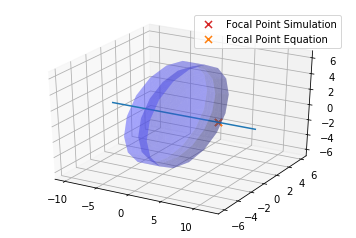

In [7]:
# Assemble the scene using trace and calculate
# the distance to the surface

scene = tr.Scene(n=1)
lens_f = tr.SphereLens(1/R1, 6, 4, pos=tr.pos(-d/2,0,0), axis=tr.vec(-1,0,0), n=N)
lens_b = tr.SphereLens(1/R2, 6, 0, pos=tr.pos(+d/2,0,0), axis=tr.vec(-1,0,0), n=1)
ray = tr.Ray(tr.pos(-10, 0.001, 0.001), k=tr.vec(1,0,0))

scene.add(lens_f, lens_b, ray)
scene.trace()

_, focal_pt = ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
# The distance to the surface is the focal point - extend of lens in positive x
print("Distance to surface: {}".format(focal_pt[0] - d/2))

ax = tr.graphics.render_3d(scene, extend=10, labels=False).axes[0]
ax.scatter(*focal_pt, label="Focal Point Simulation", marker="x", color="tab:red", s=50)
ax.scatter(distance+d/2, 0, 0, label="Focal Point Equation", marker="x", color="tab:orange", s=50)


ax.legend()
plt.show()

## Modelling a plano-convex singlet lens

This examples demonstrates how the trace package can be used to complete task 15 in the laboratory manual.

Calcualting the RMS for the curved surface facing the beam is done in great detail with plots of all intermediate steps. The other way around is done in a single cell, showing only a plot of the final scene and result.

In [8]:
# Start by preparing a scene
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the curved surface
lens_front = tr.SphereLens(0.02, 6, 5, pos=tr.pos(0,0,0), axis=tr.vec(1,0,0), n=1.5168)
lens_back = tr.PlaneLens(pos=tr.pos(-5,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1)

lamp = tr.DenseSource(pos=tr.pos(25,0,0), k=tr.vec(-1,0,0), radius=5, density=1)

scene.add(lens_front, lens_back, lamp)

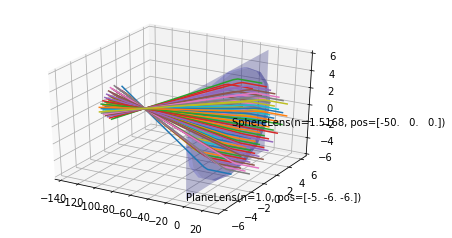

In [9]:
# Render the current scene, to validate the
# placement of objects is correct
scene.trace()
tr.graphics.render_3d(scene, extend=130)
plt.show()

In [10]:
# Find focal point using single ray
scene = scene.reset()
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace_ray(focus_ray)

pt_ray, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

Focal Point: [-98.45258785   0.           0.        ]


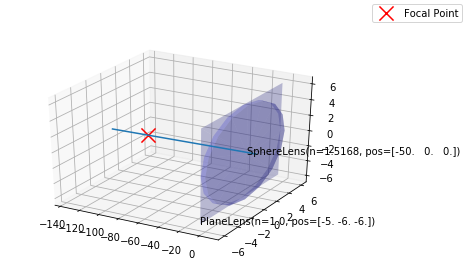

In [11]:
# Display the focal point
fig = tr.graphics.render_3d(scene, extend=130)
fig.axes[0].scatter(*pt_axi, color="red", marker="x", s=200, label="Focal Point")
fig.legend()
plt.show()

RMS: 0.007556120078896159mm


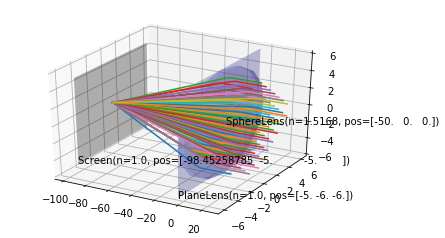

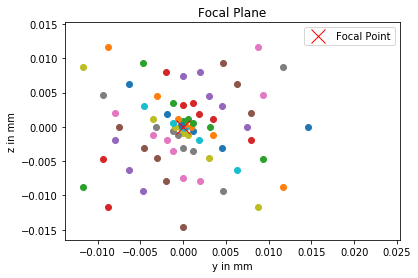

In [12]:
# Now that we know the focal point, place a screen there and record the rms
scene = scene.reset() # Note: This automagically removes the focus ray
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))

scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

Focal Point: [-101.74833565    0.            0.        ]
RMS: 0.030094346151877786mm


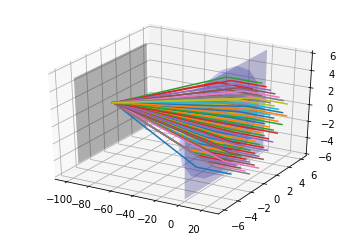

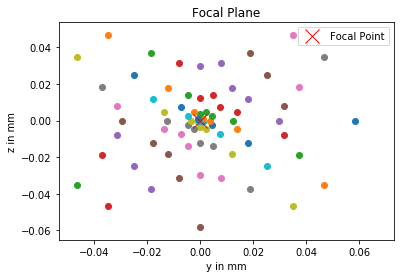

In [13]:
# Without running through all the visuals, do the same trace from the other side
scene = tr.Scene()

# Pano-convex lens (all lengths in mm)
# This lens faces the source with the flat surface
lens_front = tr.SphereLens(-0.02, 6, 0, pos=tr.pos(-5,0,0), axis=tr.vec(1,0,0), n=1)
lens_back = tr.PlaneLens(pos=tr.pos(0,-6,-6), normal=tr.vec(1,0,0), width=tr.vec(0,12,0), height=tr.vec(0,0,12), n=1.5168)

scene.add(lens_front, lens_back, lamp) # Note: Reuse lamp from above

# Find focal point
focus_ray = tr.Ray(tr.pos(8,0.1,0.1), k=tr.vec(-1,0,0))
scene.add(focus_ray)
scene.trace_ray(focus_ray)
_, pt_axi = focus_ray.intersect_axis(tr.pos(0,0,0), tr.vec(1,0,0))
print("Focal Point: {}".format(pt_axi))

# Insert screen at focal point
scene = scene.reset()
screen = tr.Screen(pos=pt_axi-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))
scene.add(screen)
scene.trace()

# Calculate RMS from focal point
print("RMS: {}mm".format(screen.RMS(pt_axi)))

# Make nice output graphics
tr.graphics.render_3d(scene, labels=False)
ax = tr.graphics.render_2d(screen).axes[0]

ax.set_title("Focal Plane")
ax.plot(pt_axi[1], pt_axi[2], "xr", label="Focal Point", markersize=14)
ax.set_xlabel("y in mm")
ax.set_ylabel("z in mm")
ax.legend()

plt.show()

### Result

This example should demonstrate the ease of use provided by trace, as well as how this lens has a much worse performace the 'wrong' way around.

Numerical results for RMS of the plano-convex lens:
1. Curved surface facing beam: ${RMS}_\text{c} = 0.00756\text{mm}$
2. Flat surface facing beam: ${RMS}_\text{f} = 0.03009\text{mm}$

The RMS when facing the beam with the flat surface is more than $30\times$ greater!

## Lens optimization

This optimizes the design of a lens using trace. This is the last task in the laboratory manual.

#### Volatile types

Geometry is immutable. This has several advantages, such as making interactive sessions like the one above
more safe and allowing very efficient implementations of things like `Scene.reset()`, which creates a new
scene, but is able to share all geometry objects.

Hovever, creating an new object every time we want to update the curvature of a lens is rather costly. To that end, `trace` introduces volatile types. These are less safe and are not supported in operations like `Scene.reset()`, but
allow for efficient in-place variation of geometry attributes. (Note that there is a special VolatileScene, that can
reset itself in-place, even if containing volatile geometry.)

To create a volatile type, any variable parameters must be passed as `Variable(initial_value)`. Before this object can
be used, it must be marked as volatile by calling `obj = make_volatile(obj)`. Once a volatile type has been marked volatile, the associated variables may  be altered at any time by calling `variable.set(new_value)`. Note, that this
does not perform runtime-checks on the new values.

(This functionality is implemented in `trace.optim`)

In [14]:
# We will need a numeric function optimizer for this, like the ones provided by scipy
import scipy.optimize as sp_optim

In [15]:
# Next, we need to defined a function that calculates the RMS based on the lens curvatures
# Our lens is 5 mm deep and has initial curvatures of 0.02

fit_scene = tr.VolatileScene(n=1)

curvature_f = tr.Variable(0.02)
curvature_b = tr.Variable(-0.02)

fit_lens_f = tr.make_volatile(tr.SphereLens(curvature_f, 6, 5, pos=tr.pos(0,0,0), axis=tr.vec(1,0,0), n=1.5168))
fit_lens_b = tr.make_volatile(tr.SphereLens(curvature_b, 6, 0, pos=tr.pos(-5,0,0), axis=tr.vec(1,0,0), n=1))

fit_lamp = tr.DenseSource(radius=5, pos=tr.pos(4,0,0), k=tr.vec(-1,0,0), density=0.8)
fit_screen = tr.Screen(pos=tr.pos(-50,0,0)-tr.vec(0,5,5), normal=tr.vec(1,0,0), width=tr.vec(0,10,0), height=tr.vec(0,0,10))

fit_scene.add(fit_lens_f, fit_lens_b, fit_lamp, fit_screen)

def fn_to_min(x):
    # Step 0: Reset the scene and apply variables
    # (this is different from resetting before, since we use a VolatileScene)
    fit_scene.reset()
    curvature_f.set(x[0])
    curvature_b.set(x[1])
    # Step 1: Trace rays and report RMS
    fit_scene.trace()
    return fit_screen.RMS(tr.pos(-50,0,0))

Initial RMS: 0.14373711379271736


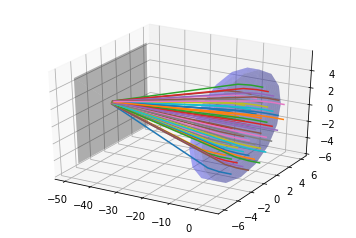

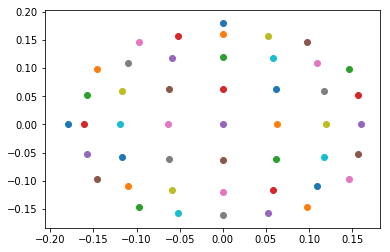

In [16]:
# Let's see if our setup is working ...
print("Initial RMS: {}".format(fn_to_min([0.02, -0.02])))
tr.graphics.render_3d(fit_scene, labels=False)
tr.graphics.render_2d(fit_screen)
plt.show()

In [17]:
# Now we use scipy to minimize fn_to_min
result = sp_optim.minimize(fn_to_min, [0.02, -0.02], bounds=[(1e-10, 0.1), (-0.1, -1e-10)])
print(result)

      fun: 0.008512098541628332
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.19619200e-05, -3.65618993e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 147
      nit: 21
   status: 0
  success: True
        x: array([ 0.03499081, -0.00548053])


Optimized RMS: 0.008512098541628332


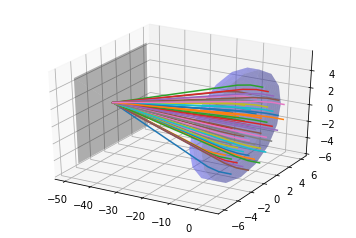

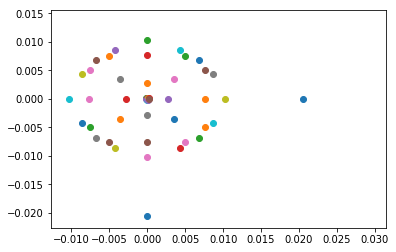

In [18]:
# Finally, we can render the resulting image
print("Optimized RMS: {}".format(fn_to_min(result.x)))
tr.graphics.render_3d(fit_scene, labels=False)
tr.graphics.render_2d(fit_screen)
plt.show()

### Result

This example should demonstrate the principles of using trace to optimize a set of variable geometry parameters.
Using a function minimizer, we found a configuration that has a focal point in the desired plane with
${RMS} = 0.00851\text{mm}$.

## Modelling a telescope

This example uses trace to model a simple telescope, which uses one collimating mirror, a second mirror to redirect
the beam and a lens to restore the rays being parallel. Essentially, the setup will shrink a big beam into a smaller
one.

Trace is used to model this telescope and to adjust the properties of the terminating lens to achieve a parallel
beam at the end.

In [19]:
# As per usual, we start with a scene
scene = tr.VolatileScene()

# We will choose a refractive index and curvature to get a nice even picture
# (just to demonstrate, that we can vary any parameter that is a scalar)
ref_index = tr.Variable(15)
curv_eyepiece = tr.Variable(0.02)
curv_eyepiece_neg = tr.Variable(-0.02)

# Place mirrors and lenses to assemble our telescope
big_mirror = tr.SphereMirror(-0.035, 6, 1, pos=tr.pos(0,0,0), axis=tr.vec(0,-1,0))
small_mirror = tr.PlaneMirror(pos=tr.pos(-1,-10,-1), width=tr.vec(2,0,0), height=tr.vec(0,-2,2), normal=tr.vec(0,1,1))
eyepiece_b = tr.make_volatile(tr.SphereLens(curv_eyepiece, 2, 1, pos=tr.pos(0,-10.8,6), axis=tr.vec(0,0,-1), n=ref_index))
eyepiece_t = tr.make_volatile(tr.SphereLens(curv_eyepiece_neg, 2, 1, pos=tr.pos(0,-10.8,7), axis=tr.vec(0,0,-1), n=1))
screen = tr.Screen(pos=tr.pos(-2,-12.8,10), width=tr.vec(4,0,0), height=tr.vec(0,4,0), normal=tr.vec(0,0,-1))

the_universe_or_something = tr.DenseSource(pos=tr.pos(0,-20,0), k=tr.vec(0,1,0), radius=5.5, density=1)

scene.add(big_mirror, small_mirror, eyepiece_b, eyepiece_t, screen)
scene.add(the_universe_or_something)

In [20]:
# We will get parallel beams on the screen, by minimizing
# the sum of the differences in k-vectors
def min_max_difference(x):
    # Step 0: Reset the scene and apply variables
    # (this is different from resetting before, since we use a VolatileScene)
    scene.reset()
    ref_index.set(x[0])
    curv_eyepiece.set(x[1])
    curv_eyepiece_neg.set(-x[1])
    # Step 1: Trace rays
    scene.trace()
    # Step 2: We want our beam to be nice and parallel
    k_0 = tr.vec(1,1,0)
    return sum([abs(k_0.dot(ray.k)) for ray in screen.hits])

In [21]:
import scipy.optimize as sp_optim # in case, this example is run on its own

In [22]:
result = sp_optim.minimize(
    min_max_difference,
    [15, 0.02],
    method="SLSQP",
    bounds=[(1, 5), (0.01, 1.0)])
print(result)

     fun: 3.6107140581857693
     jac: array([-0.23142874, -6.02593619])
 message: 'Optimization terminated successfully.'
    nfev: 142
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([2.74126656, 0.09947218])


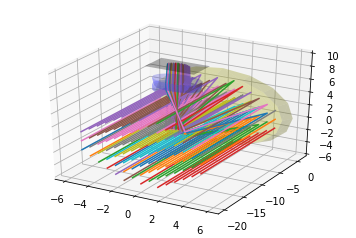

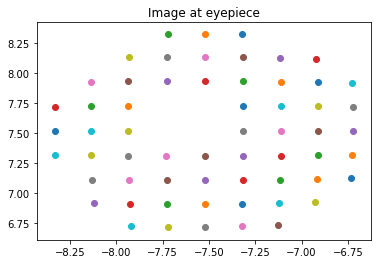

In [23]:
# Render the result
scene.reset()
scene.trace()

tr.graphics.render_3d(scene, extend=0, labels=False)
ax = tr.graphics.render_2d(screen).axes[0]
ax.set_title("Image at eyepiece")
plt.show()

### Result

This example demonstrates a more complex scene. The principle of optimizing given geometry parameters is the same
as in the previous example.

The final image output shows a nice (appriximately) even patter on the output plane.